In [50]:
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install shap
!pip install kneed



You should consider upgrading via the '/home/nina/Schreibtisch/HCI/Projekt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/nina/Schreibtisch/HCI/Projekt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/nina/Schreibtisch/HCI/Projekt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/nina/Schreibtisch/HCI/Projekt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/nina/Schreibtisch/HCI/Projekt/venv/bin/python -m pip install --upgrade pip' command.


Sample type: 

Zuordnung:

{'First Recurrence': np.int64(0), 'Tumor Primary': np.int64(1), 'n Recurrence': np.int64(2)}


/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.503597   0.478327  0.503597  0.446676
2                  SVM  0.503597   0.478327  0.503597  0.446676
3    Gradient Boosting  0.517986   0.523713  0.517986  0.446607
4              XGBoost  0.517986   0.523713  0.517986  0.446607
6        Decision Tree  0.517986   0.523713  0.517986  0.446607
5                  KNN  0.460432   0.478106  0.460432  0.354454
1  Logistic Regression  0.273381   0.301269  0.273381  0.228485
7          Naive Bayes  0.172662   0.289762  0.172662  0.098339


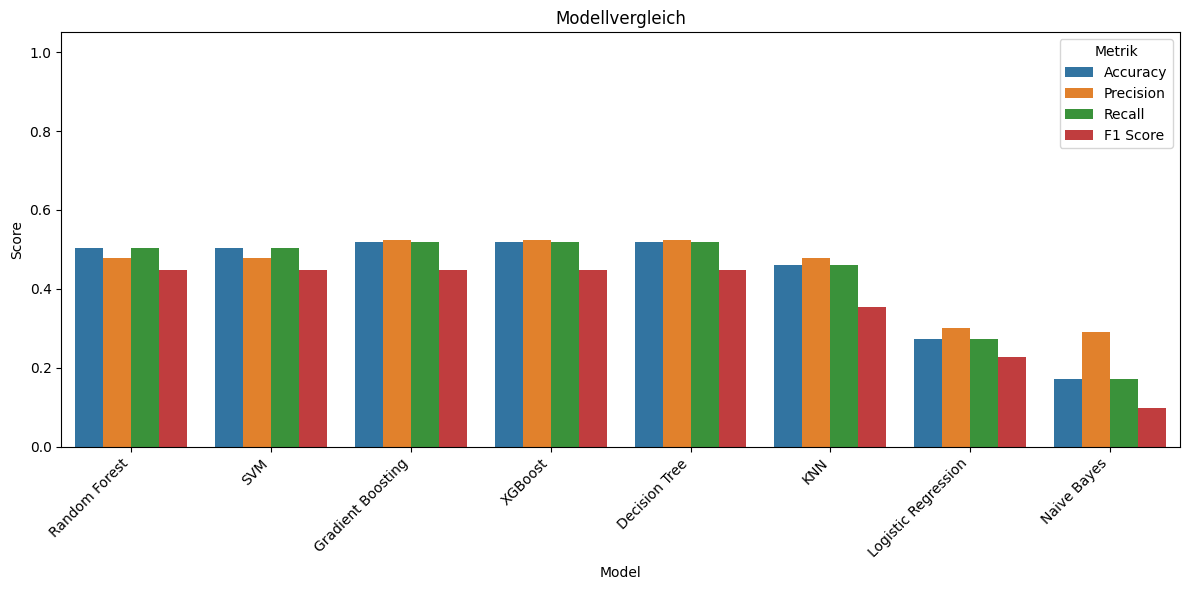

Random Forest Ergebnisse
Accuracy: 0.273

Confusion Matrix:
 [[ 0 10 50]
 [ 0 20 40]
 [ 0  1 18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.65      0.33      0.44        60
           2       0.17      0.95      0.28        19

    accuracy                           0.27       139
   macro avg       0.27      0.43      0.24       139
weighted avg       0.30      0.27      0.23       139



/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

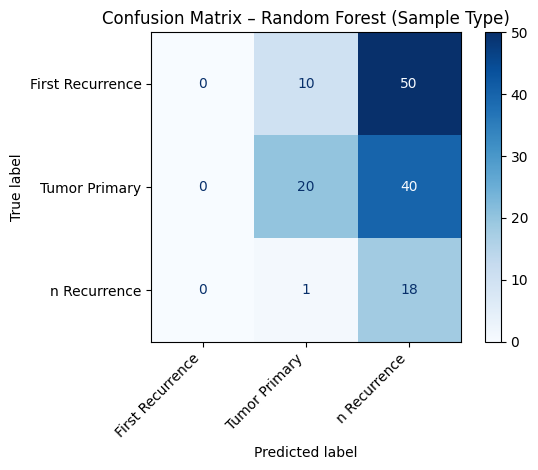

Logistic Regression Ergebnisse
Accuracy: 0.273

Confusion Matrix:
 [[ 0 10 50]
 [ 0 20 40]
 [ 0  1 18]]

Classification Report:
                   precision    recall  f1-score   support

First Recurrence       0.00      0.00      0.00        60
   Tumor Primary       0.65      0.33      0.44        60
    n Recurrence       0.17      0.95      0.28        19

        accuracy                           0.27       139
       macro avg       0.27      0.43      0.24       139
    weighted avg       0.30      0.27      0.23       139



/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

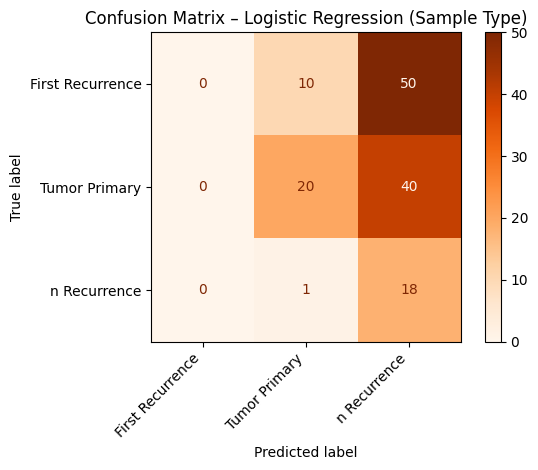

Decision Tree Ergebnisse
Accuracy: 0.518

Confusion Matrix:
 [[55  5  0]
 [43 17  0]
 [18  1  0]]

Classification Report:
                   precision    recall  f1-score   support

First Recurrence       0.47      0.92      0.62        60
   Tumor Primary       0.74      0.28      0.41        60
    n Recurrence       0.00      0.00      0.00        19

        accuracy                           0.52       139
       macro avg       0.40      0.40      0.34       139
    weighted avg       0.52      0.52      0.45       139



/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

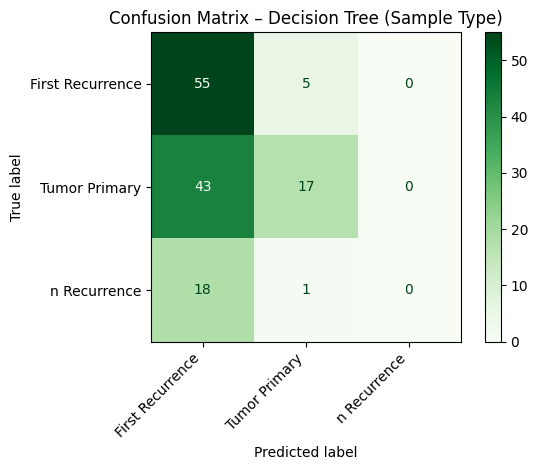

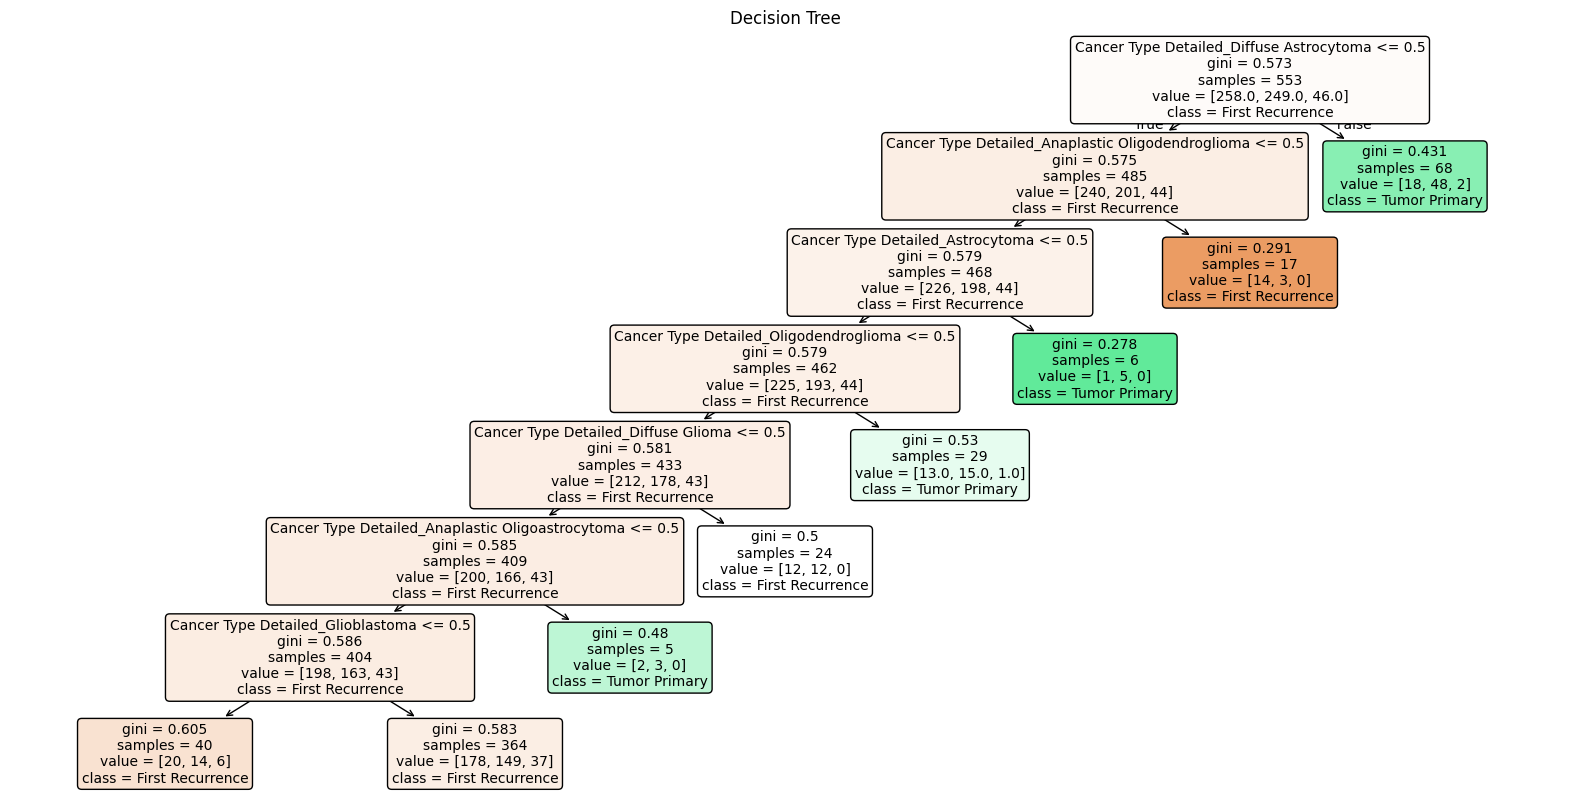

/tmp/ipykernel_86553/526443590.py:223: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='coolwarm')


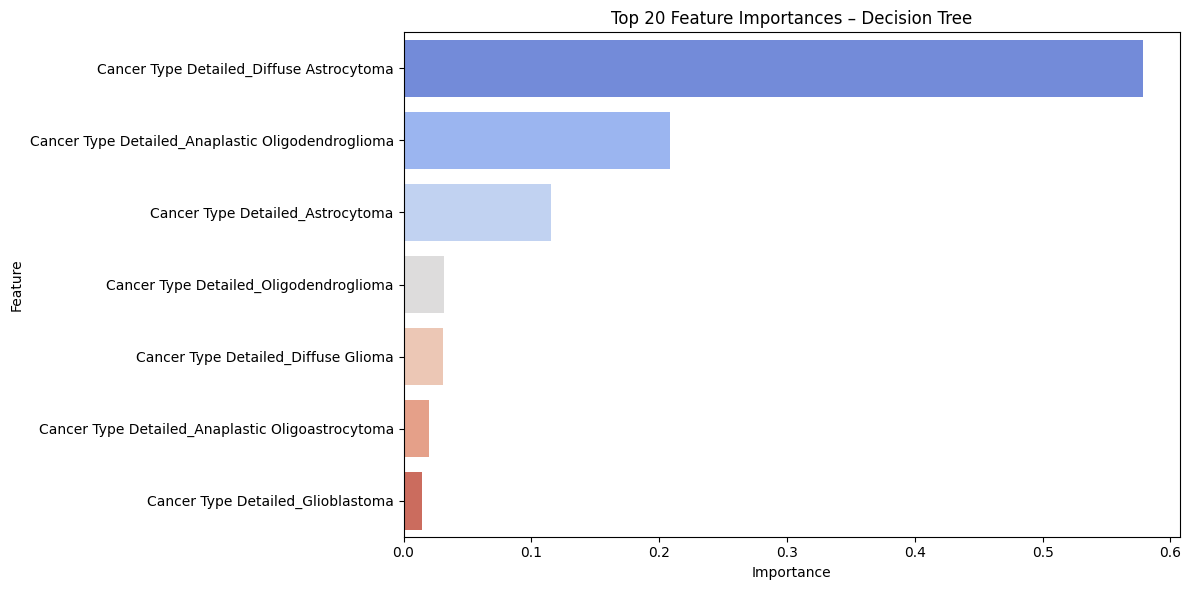

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import plot_tree

clinical_data = pd.read_csv("hcai_data-main/difg_glass_clinical_data_reduced.tsv.txt", sep="\t")

#print("Part 1:")
#print(clinical_data.shape)
#print(clinical_data.columns[:10])  #ersten 10 Spalten


##### auf sample type klassifizieren
print("Sample type: \n")
#print(clinical_data["Sample Type"])
clinical_data = clinical_data.dropna(subset=["Sample Type"]) #leere werte dropen
#survival columns dropen
clinical_data= clinical_data.drop("Overall Survival", axis='columns')
clinical_data= clinical_data.drop("Overall Survival (months)", axis='columns')
#print(clinical_data)
#labels: First Metastasis, Tumor Primary, First Recurrence, Second Recurrence, Third Recurrence, Fourth recurrence

#### drei klassen ###
def simplify_sample_type(sample):
    sample = sample.strip().lower()
    if "second recurrence" in sample or "third recurrence" in sample or "fourth recurrence" in sample:
        return "n Recurrence"
    elif "first recurrence" in sample:
        return "First Recurrence"
    elif "tumor primary" in sample:
        return "Tumor Primary"
    elif "first metastasis" in sample:
        return "REMOVE"
    else:
        return np.nan

clinical_data["Sample Type Simplified"] = clinical_data["Sample Type"].apply(simplify_sample_type)
clinical_data = clinical_data[clinical_data["Sample Type Simplified"].notna()]
clinical_data = clinical_data[clinical_data["Sample Type Simplified"] != "REMOVE"]


cols = ["Sample Type Simplified", "Cancer Type Detailed"]
df = clinical_data[cols].copy()



df_encoded = pd.get_dummies(df,
    columns=[
              "Cancer Type Detailed"],
    drop_first=True
)

#label encoder verwenden, damit z.B. 0 = First Recurrence

encoder = LabelEncoder()
y = encoder.fit_transform(df_encoded["Sample Type Simplified"])
print("Zuordnung:\n")
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

X = df_encoded.drop(columns=["Sample Type Simplified"])#features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

########################## modelle ########################
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1 Score": f1_score(y_test, y_pred, average='weighted')
    })

results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print(results_df)

plt.figure(figsize=(12,6))
sns.barplot(data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Model", y="Score", hue="Metric")
plt.title("Modellvergleich")
plt.ylim(0,1.05)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title="Metrik")
plt.show()

######################################################################



# train - random forest
model = RandomForestClassifier(class_weight="balanced",random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print("Random Forest Ergebnisse")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
#print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=encoder.classes_))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


#ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=encoder.classes_, cmap='Blues')
labels = unique_labels(y_test, y_pred)
class_names = encoder.inverse_transform(labels)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=class_names,
    cmap='Blues'
)
plt.title("Confusion Matrix – Random Forest (Sample Type)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


log_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("Logistic Regression Ergebnisse")
print("Accuracy:", round(accuracy_score(y_test, y_pred_log), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
#print("\nClassification Report:\n", classification_report(y_test, y_pred_log, target_names=encoder.classes_))


#ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test, display_labels=encoder.classes_, cmap='Oranges')
labels_log = unique_labels(y_test, y_pred_log)
class_names_log = encoder.inverse_transform(labels_log)

print("\nClassification Report:\n",
      classification_report(y_test, y_pred_log,
                            labels=labels_log,
                            target_names=class_names_log))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_log,
    display_labels=class_names_log,
    cmap='Oranges'
)
plt.title("Confusion Matrix – Logistic Regression (Sample Type)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ------------------ Decision Tree ------------------ #
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

print("Decision Tree Ergebnisse")
print("Accuracy:", round(accuracy_score(y_test, y_pred_tree), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))

labels_tree = unique_labels(y_test, y_pred_tree)
class_names_tree = encoder.inverse_transform(labels_tree)

print("\nClassification Report:\n",
      classification_report(y_test, y_pred_tree,
                            labels=labels_tree,
                            target_names=class_names_tree))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_tree,
    display_labels=class_names_tree,
    cmap='Greens'
)
plt.title("Confusion Matrix – Decision Tree (Sample Type)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,10))
plot_tree(tree_model, 
          feature_names=X.columns, 
          class_names=encoder.classes_,
          filled=True, 
          rounded=True,  
          fontsize=10)
plt.title("Decision Tree")
plt.show()

# ------------------ Feature Importance Visualisierung ------------------ #
importances = tree_model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Top 20 Features
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='coolwarm')
plt.title("Top 20 Feature Importances – Decision Tree")
plt.tight_layout()
plt.show()

#non_gene_cols = ["STUDY_ID", "SAMPLE_ID", "Cancer Type Detailed",	"Overall Survival (months)",	"Overall Survival"	,"Sample Type"]


/tmp/ipykernel_86553/4234948228.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_genes = combined_data[gene_cols].applymap(lambda x: 0 if str(x).strip().upper() == "WT" else 1)


 Decision Tree Accuracy (Mutationsdaten): 0.4172661870503597
shap_values_g.shape = (139, 1700, 3)
X_test_g.shape = (139, 1700)


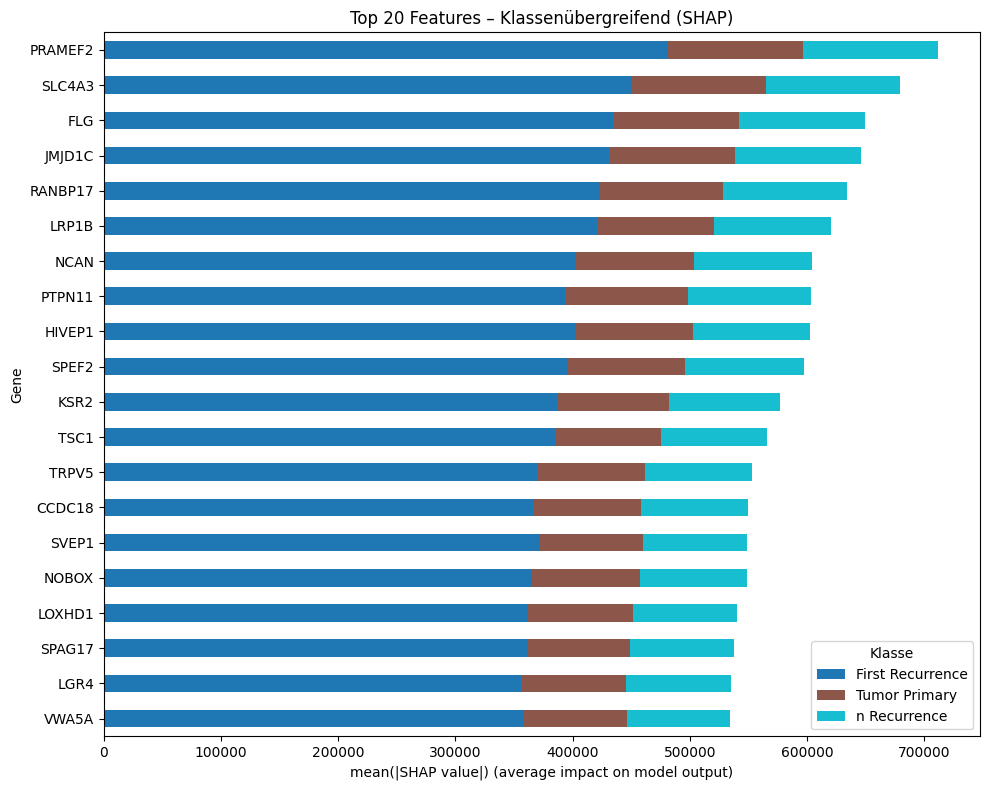

In [52]:
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# ------------------------------
# 1) neue daten
# ------------------------------
combined_data = pd.read_csv("hcai_data-main/combined_data.tsv.txt", sep="\t")

combined_data["Sample Type Simplified"] = combined_data["Sample Type"].apply(simplify_sample_type)

combined_data = combined_data[combined_data["Sample Type Simplified"].notna()]
combined_data = combined_data[combined_data["Sample Type Simplified"] != "REMOVE"]

non_gene_cols = ["STUDY_ID_x", "SAMPLE_ID", "Cancer Type Detailed", "Overall Survival (months)", "Overall Survival", "Sample Type"]
gene_cols = [col for col in combined_data.columns if col not in non_gene_cols]
X_genes = combined_data[gene_cols].applymap(lambda x: 0 if str(x).strip().upper() == "WT" else 1)

y_genes = combined_data["Sample Type Simplified"]
encoder_genes = LabelEncoder()
y_genes_enc = encoder_genes.fit_transform(y_genes)

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_genes, y_genes_enc, stratify=y_genes_enc, test_size=0.2, random_state=42
)

# Decision Tree trainiern
tree_model_g = DecisionTreeClassifier(max_depth=None, random_state=42)
tree_model_g.fit(X_train_g, y_train_g)

print(" Decision Tree Accuracy (Mutationsdaten):", tree_model_g.score(X_test_g, y_test_g))

# SHAP Werte
explainer_g = shap.TreeExplainer(tree_model_g)
#explainer_g = shap.TreeExplainer(tree_model_g, feature_perturbation="interventional")

shap_values_g = explainer_g.shap_values(X_test_g,check_additivity=False)

print("shap_values_g.shape =", np.array(shap_values_g).shape)
print("X_test_g.shape =", X_test_g.shape)

## Mittelwert über alle Samples pro Klasse
shap_class_array = np.abs(shap_values_g).mean(axis=0)  # shape: (n_features, n_classes)

# DataFrame bauen
shap_class_df = pd.DataFrame(
    shap_class_array,
    index=X_test_g.columns,          # Gene als Zeilen
    columns=encoder_genes.classes_   # Klassen als Spalten
)

# Total berechnen (klassenübergreifend)
shap_class_df["Total"] = shap_class_df.sum(axis=1)

# Top 20 Gene
top_20_features = shap_class_df.sort_values("Total", ascending=False).head(20)
top_20_features = top_20_features.drop(columns="Total")

# Plotten
top_20_features.plot(kind="barh", stacked=True, figsize=(10, 8), colormap="tab10")
plt.xlabel("mean(|SHAP value|) (average impact on model output)")
plt.ylabel("Gene")
plt.title("Top 20 Features – Klassenübergreifend (SHAP)")
plt.legend(title="Klasse")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




#############################################################################

####### die wichtigsten features herausfinden  (klassenübergreifend) #####
#mean_abs_shap = np.mean(np.abs(shap_values_g), axis=(0, 1))

#if shap_values_g.ndim == 3:
    #mean_abs_shap = np.mean(np.abs(shap_values_g), axis=(0, 1))
#else:
    #mean_abs_shap = np.mean(np.abs(shap_values_g), axis=0)

### DataFrame bauen
#overall_importance_df = pd.DataFrame(
    #zip(X_test_g.columns, mean_abs_shap),
    #columns=["Feature", "Mean_Abs_SHAP"]
#).sort_values(by="Mean_Abs_SHAP", ascending=False)


# Top 20 Features
#top_20 = overall_importance_df.head(20)

# Plot
#plt.figure(figsize=(10, 8))
#sns.barplot(data=top_20, x="Mean_Abs_SHAP", y="Feature", color="skyblue")
#plt.title("Top 20 Features (klassenübergreifende SHAP Importance)")
#plt.xlabel("Mean |SHAP value| (global)")
#plt.ylabel("Feature")
#plt.tight_layout()
#plt.show()

#print("Top 20 Features:\n", top_20)

##########################






 Klasse: First Recurrence


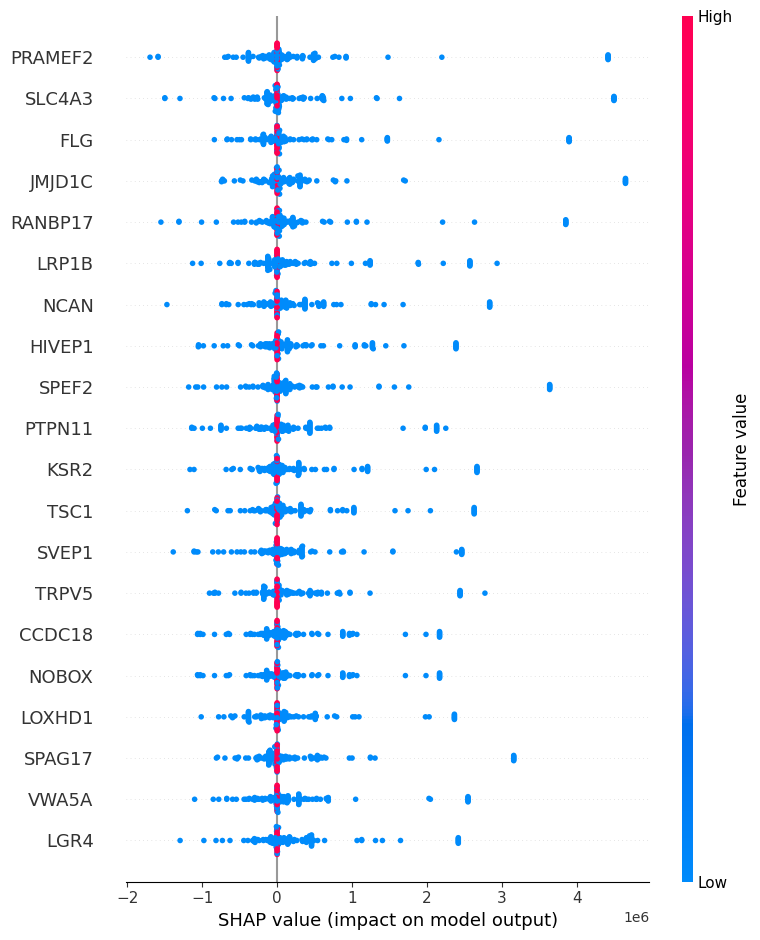


 Klasse: Tumor Primary


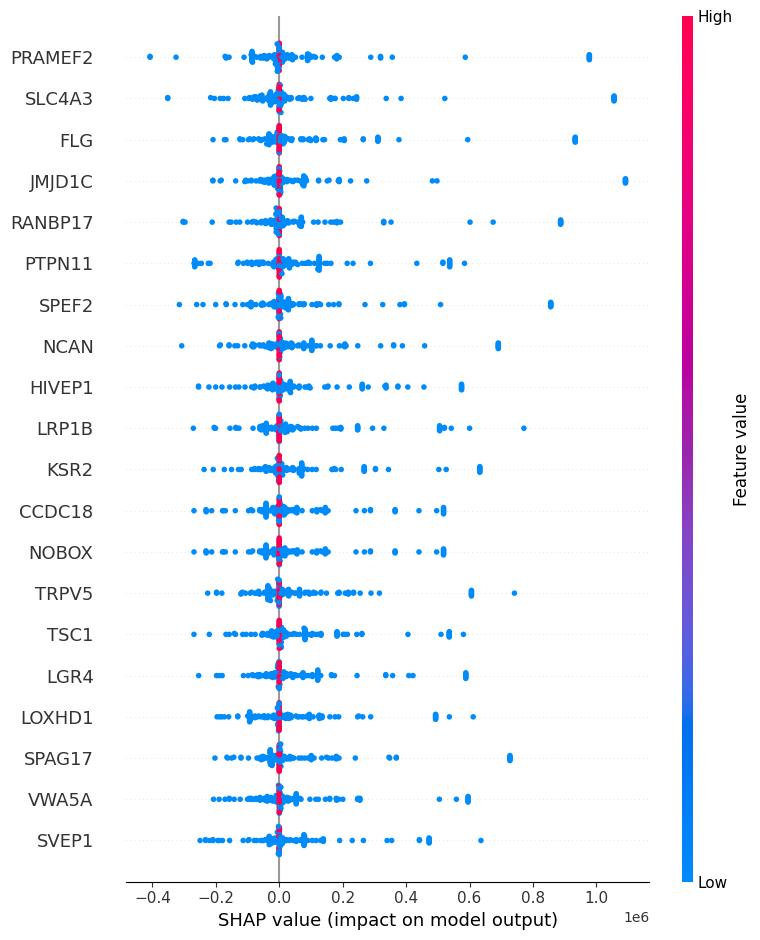


 Klasse: n Recurrence


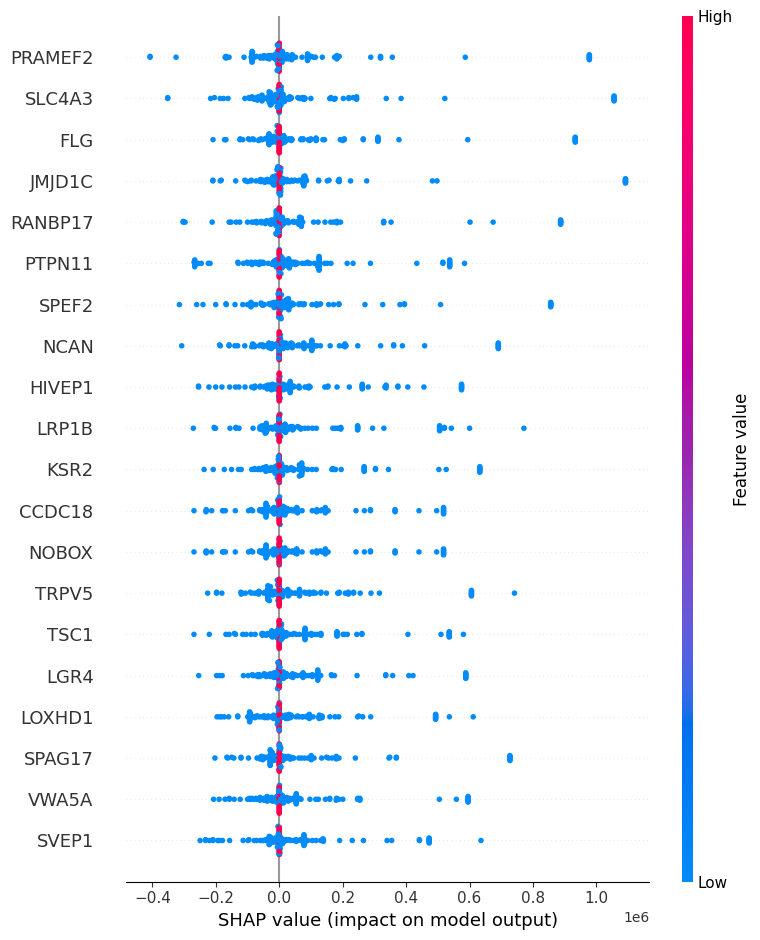

In [53]:
# Summary Plot (jede Klasse )
n_classes = len(shap_values_g)#shap_values_g.shape[2]

for i, class_name in enumerate(encoder_genes.classes_):
    sv = shap_values_g[:, :, i]   # slicen
    print(f"\n Klasse: {class_name}")
    #print(f"sv.shape = {sv.shape}, X_test_g.shape = {X_test_g.shape}")

    assert sv.shape == X_test_g.shape, f"Shape mismatch: sv={sv.shape} vs X_test_g={X_test_g.shape}"

    shap.summary_plot(
        sv,
        X_test_g,
        plot_type="dot",
        max_display=20,
        show=True
    )


########## wichtigkeit der gene ?

KneeLocator import erfolgreich


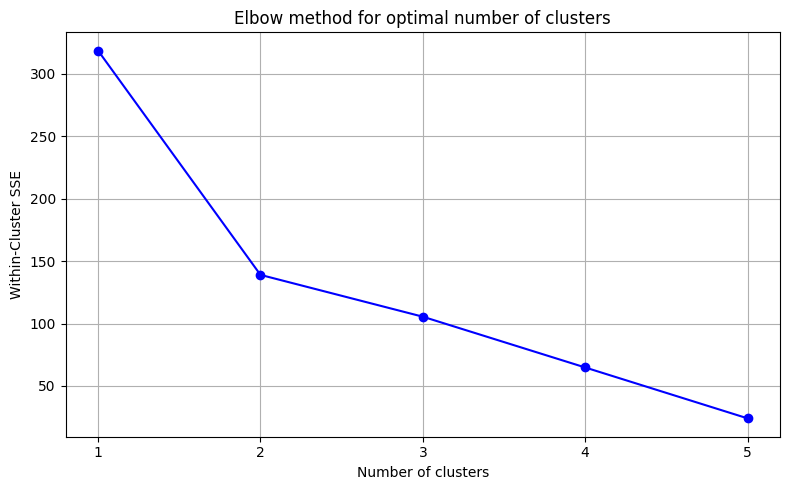

Optimal number of clusters according to elbow method: 2



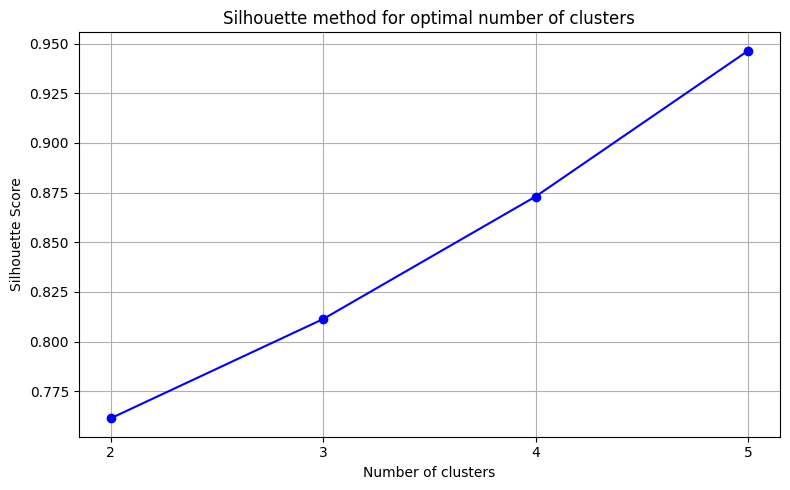

Optimal number of clusters according to silhouette method: 5
Cluster vs. RSample Type Simplified

Rounded crosstab value Sample Type Simplified  Tumor Primary  First Recurrence  n Recurrence
Cluster                                                              
0                                0.40              0.48          0.12
1                                0.54              0.41          0.04


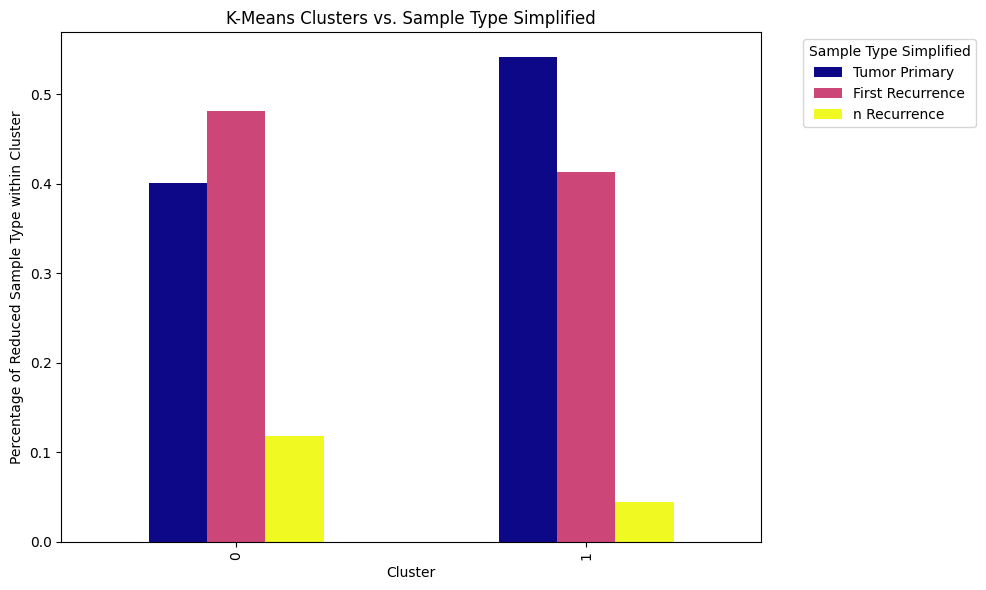

Number of samples per cluster

Sample Type Simplified  Tumor Primary  First Recurrence  n Recurrence
Cluster                                                              
0                                 187               225            55
1                                 122                93            10


In [54]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from kneed import KneeLocator



#------Elbow method to find optimal number of clusters----#
sse = [] #ssum of sqaured errors
K = range(1, 6) 

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, sse, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster SSE')
plt.title('Elbow method for optimal number of clusters')
plt.xticks(K)
plt.grid(True)
plt.tight_layout()
plt.show()

#kneelocator to print out optimal number of clusters
knee = KneeLocator(K, sse, curve='convex', direction='decreasing')
print(f"Optimal number of clusters according to elbow method: {knee.knee}\n")

#------Silhouette method to evaluate cluster quality----#

silhouette_scores = []
K_sil = range(2, 6) 

for k in K_sil:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K_sil, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette method for optimal number of clusters')
plt.xticks(K_sil)
plt.grid(True)
plt.tight_layout()
plt.show()

best_k = K_sil[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters according to silhouette method: {best_k}")

#---------K-Means---------#
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)

X["Cluster"] = clusters

# labels nicht encoded
df_analysis = df_encoded.copy()
df_analysis["Cluster"] = clusters
df_analysis["Sample Type"] = df["Sample Type Simplified"].values 

#-----comparison Cluster vs. Sample Type------#
#crosstab computes a simple cross tabulation of two (or more) factors
column_order = ["Tumor Primary", "First Recurrence", "n Recurrence"]
crosstab = pd.crosstab(df_analysis["Cluster"], df_analysis["Sample Type Simplified"], normalize='index')[column_order]
print("Cluster vs. RSample Type Simplified\n")
print("Rounded crosstab value", crosstab.round(2))
crosstab.plot(kind='bar', stacked=False, colormap='plasma', figsize=(10,6))
plt.title("K-Means Clusters vs. Sample Type Simplified")
plt.ylabel("Percentage of Reduced Sample Type within Cluster")
plt.xlabel("Cluster")
plt.legend(title="Sample Type Simplified", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#number of each Sample Types per cluster 
raw_crosstab = pd.crosstab(df_analysis["Cluster"], df_analysis["Sample Type Simplified"])[column_order]
print("Number of samples per cluster\n")
print(raw_crosstab)
